# K-Fold Valdation and Box-Whisker Plot Evaluation

In this notebook, I will use the K-Fold validation technique to evaluate the performance of our models. The 2 models trained and evaluated here have been fine tuned already. The purpose of this notebook is to verify that the hyperparameters chosen from ```Simple_Model_Trainer.ipynb``` are correct. Lastly, I will also use the box-whisker plot to visualize the performance of these models.

In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from ImageToArrayPreprocessor import ImageToArrayPreprocessor
from SimplePreprocessor import SimplePreprocessor
from DataLoader import DataLoader
from ShallowNet import ShallowNet
from NovelCNN import NovelCNN
from tensorflow.keras.optimizers import Adam
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import os

Most of the code is in this cell. The same classes (SimpleProcessor, DataLoader, ImageToArrayPreprocessor, and LabelBinarizer) are used here. This time the entire dataset is loaded into the X and y variables. This is so that each fold can be trained, validated, and tested on different datasplits each time. The code also depends on whether the results.json file exists or not. Training the Novel CNN for 2000 epochs each fold took time, so I did not want to repeat the process.

The rest of the code implements K-Fold validation. With this technique each model is trained, validated and tested K times and each time this is done on different data splits. As soon as the model is trained, 4 metrics are calculated and stored in the results.json file. These metrics are: the accuracy, the precision, the recall, and the F1 score.

In [2]:
%%capture
# Run the validation if results.json file is not present
if not os.path.exists("results.json"):
    # Data loading
    imagePaths = list(paths.list_images("../Part 1/image_dataset/corpus/"))
    sp = SimplePreprocessor(32, 32)
    iap = ImageToArrayPreprocessor(dataFormat="channels_last")
    sdl = DataLoader(preprocessors=[sp, iap])
    # Load all the data in X and y
    X, y = sdl.load(imagePaths)
    lb = LabelBinarizer()
    y = lb.fit_transform(y)

    # do k fold validation on a shallownet and novel cnn
    # store the results in a dictionary
    results = {"shallow": [], "novel": []}

    # k-fold validation
    for k in range(10):
        # phase between shallow and novel cnn
        for phase in ("shallow", "novel"):
            # split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=k)
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=k)

            # initialize the optimizer and model
            if phase == "shallow":
                opt = Adam()
                model = ShallowNet.build(width=32, height=32, depth=3, classes=len(lb.classes_))
                n_epochs = 100
            else:
                opt = Adam()
                model = NovelCNN.build(width=32, height=32, depth=3, classes=len(lb.classes_))
                n_epochs = 2000

            model.compile(loss="categorical_crossentropy", optimizer=opt)

            # train the network
            model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=512, epochs=n_epochs)

            # evaluate the network
            predictions = model.predict(X_test, batch_size=32)
            # store the results
            results[phase].append(  {
                                        "accuracy_score": accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)),
                                        "f1_score": f1_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average='weighted'), 
                                        "precision": precision_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average='weighted'), 
                                        "recall": recall_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average='weighted') 
                                    })
    # save the results to a json file
    with open("results.json", "w") as f:
        json.dump(results, f)

# else load the results from the json file
else:
    with open("results.json", "r") as f:
        results = json.load(f)

Now that the results are in hand, the box-whisker plot is created. This plot shows the distribution of the metrics for each model and plot is used to determine if the hyperparameters are optimal.

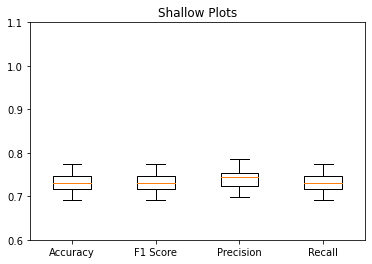

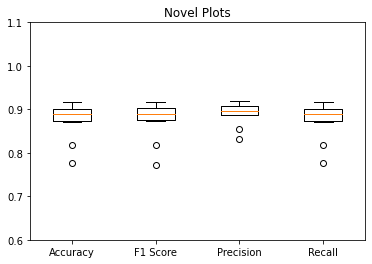

In [3]:
# for each model, plot the accuracy, f1, precision and recall
for phase in ("shallow", "novel"):
    accuracies = [x["accuracy_score"] for x in results[phase]]
    f1s = [x["f1_score"] for x in results[phase]]
    precisions = [x["precision"] for x in results[phase]]
    recalls = [x["recall"] for x in results[phase]]
    plots = (accuracies, f1s, precisions, recalls)
    labels = ("Accuracy", "F1 Score", "Precision", "Recall")
    
    # plot plots and their labels as a boxplot
    plt.figure()
    plt.boxplot(plots)
    plt.xticks([1, 2, 3, 4], labels)
    plt.yticks(np.arange(0.6, 1.1, 0.1))
    plt.title("{} Plots".format(phase.title()))
    plt.savefig("{}_Box_and_Whisker.png".format(phase))
    plt.show()